In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import os
import scipy.io
import scipy.signal

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import tensorflow as tf
np.random.seed(1337)

In [2]:
low_file = r"D:\test_development\Battery\data1\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\10degC\all_second.csv"
mid_file = r"D:\test_development\Battery\data1\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\25degC\all_second.csv"
high_file = r"D:\test_development\Battery\data1\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\40degC\all_second.csv"

In [38]:
def combine(files):
    x_all = pd.DataFrame()
    y_all = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file)
        x_df = pd.DataFrame(df[['Voltage', 'Current', 'Temperature']])
        y_df = pd.DataFrame(df['Capacity'])

        x_all = pd.concat([x_all, x_df], ignore_index=True)
        y_all = pd.concat([y_all, y_df], ignore_index=True)

    return x_all, y_all

def train_test_plot(x, y):
    df = pd.concat([x, y], axis=1)
    df.iloc[:,0].plot(figsize=(16, 4), legend=True)
    df.iloc[:,1].plot(figsize=(16, 4), legend=True)
    df.iloc[:,2].plot(figsize=(16, 4), legend=True)
    df.iloc[:,3].plot(figsize=(16, 4), legend=True)
    df.iloc[:,4].plot(figsize=(16, 4), legend=True)
    df.iloc[:,5].plot(figsize=(16, 4), legend=True)
    plt.legend(['Voltage', 'Current', 'Temperature', 'Avg. Voltage', 'Avg. Current', 'Capacity'])
    plt.title("Line Graph")
    plt.show()

def handle(x_df, y_df):
    x_df.fillna(method='ffill', inplace=True)
    y_df.fillna(method='ffill', inplace=True)
    x_df = (x_df - x_df.min()) / (x_df.max() - x_df.min())
    y_df = (y_df - y_df.min()) / (y_df.max() - y_df.min())

    b, a = scipy.signal.butter(1, 0.001, btype='lowpass', output='ba')
    x_df['Avg. Voltage'] = scipy.signal.filtfilt(b, a, x_df.loc[:,'Voltage'])
    x_df['Avg. Current'] = scipy.signal.filtfilt(b, a, x_df.loc[:,'Current'])
    return x_df, y_df

c:\Users\user\anaconda3\envs\sfdd\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


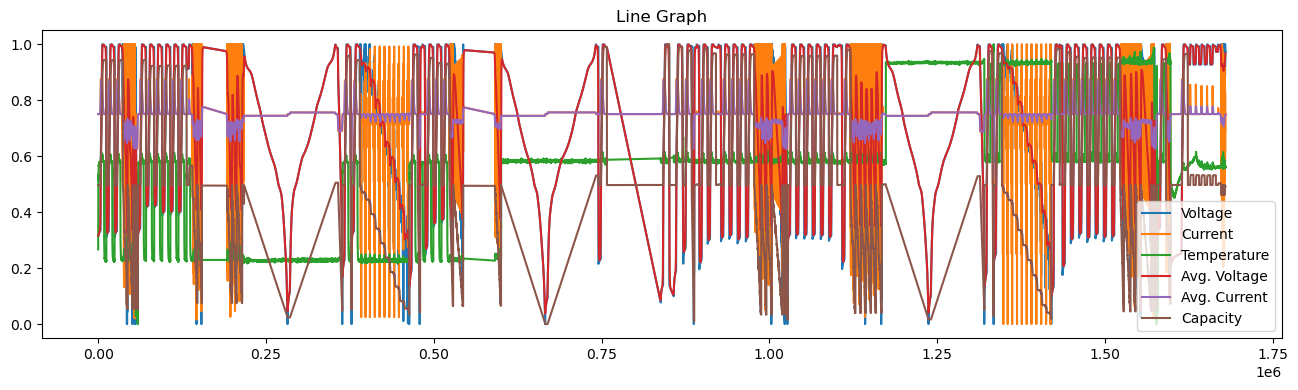

In [39]:
x_df, y_df = combine([low_file, mid_file, high_file])
x_df, y_df = handle(x_df, y_df)
train_test_plot(x_df, y_df)

In [40]:
x_train, x_test = train_test_split(x_df, shuffle=False, test_size=0.2)
y_train, y_test = train_test_split(y_df, shuffle=False, test_size=0.2)

def clipped_relu(x):
    return tf.keras.activations.relu(x, max_value=1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(21, activation='tanh'),
  tf.keras.layers.Dense(19, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
  tf.keras.layers.Dense(1, activation=clipped_relu)
])

model.compile(optimizer='adam',
  loss='mse',
)


history = model.fit(
  x_train.values,
  y_train.values,
  epochs=100,
  validation_split=0.25,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
  batch_size=256,
)

Train on 1007877 samples, validate on 335959 samples
Epoch 1/100
1007877/1007877 [==============================] - 7s 6us/sample - loss: 0.0223 - root_mean_squared_error: 0.1495 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1508
Epoch 2/100
1007877/1007877 [==============================] - 6s 6us/sample - loss: 0.0158 - root_mean_squared_error: 0.1257 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1326
Epoch 3/100
1007877/1007877 [==============================] - 6s 6us/sample - loss: 0.0149 - root_mean_squared_error: 0.1219 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1293
Epoch 4/100
1007877/1007877 [==============================] - 6s 6us/sample - loss: 0.0144 - root_mean_squared_error: 0.1199 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1299
Epoch 5/100
1007877/1007877 [==============================] - 6s 6us/sample - loss: 0.0140 - root_mean_squared_error: 0.1183 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1339
Epoch 6/100
1007877/1007877 [===

335960/335960 [==============================] - 6s 19us/sample - loss: 0.0178 - root_mean_squared_error: 0.1333


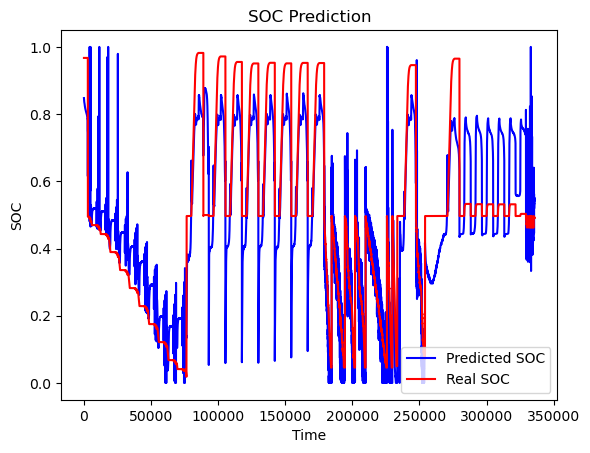

In [42]:
model.evaluate(x_test, y_test)

prediction = model.predict(x_test)
real = y_test.reset_index(drop=True)

# Visualising the results
plt.plot(prediction, color = 'blue', label = 'Predicted SOC')
plt.plot(real, color = 'red', label = 'Real SOC')
plt.title('SOC Prediction')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.legend()
plt.show()